In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

import numpy as np
import pandas as pde_diff_new
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *
from solvel0 import solvel0

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

from function_collections import msemse

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
data = sio.loadmat("/Users/pongpisit/Desktop/research/examples/pde/reaction_diffusion_equations.mat")

In [3]:
t = data['tt'][:,0]; dt = t[1]-t[0]
x = np.linspace(-1, 1, data['l1'][0,0]); dx = x[1]-x[0]
# x = np.linspace(-1, 1, data['l1'][0,0]+1)[:-1]; dx = x[1]-x[0]
u_sol = data['usol']
v_sol = data['vsol']
w_sol = data['wsol']

In [4]:
u = np.zeros((len(x), len(t), 3))
u[:, :, 0] = u_sol
u[:, :, 1] = v_sol
u[:, :, 2] = w_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x, y: x * y,
]
library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
]

np.random.seed(1234)
X, T = np.meshgrid(x, t)
spatiotemporal_grid = np.asarray([X, T]).T

weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    K=10000,
    is_uniform=True,
    include_interaction=True,
    interaction_only=True,
    include_bias=False,
    periodic=True,
    cache=True
)

noise_lv = 0.1
u = u + 0.01*noise_lv*np.std(u)*np.random.randn(*u.shape)

In [5]:
optimizer = ps.STLSQ(alpha=200, threshold=1e-3, normalize_columns=False)
# optimizer = ps.MIOSR(target_sparsity=6, normalize_columns=False)
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer, cache=True, feature_names=['u', 'v', 'w'])
model.fit(u, ensemble=False, library_ensemble=False)
model.print()

(u)' = 0.002 u_11 + 0.091 uu_11
(v)' = 0.006 v_11 + 0.186 wv_11
(w)' = 0.009 u_11 + 0.026 v_11 + 0.098 uw_11 + 0.002 uww_11


In [6]:
X_pre, y_pre = model.feature_library.cached_xp_full[0], model.cached_x_dot
w_pre = y_pre[:,2:3]

In [7]:
# Note that 11th feature be effective if is_normal = True
is_normal = True
solve_grb = solvel0(X_pre, w_pre, is_normal=is_normal, max_complexity=10, refine=True)

  0%|                                                                                                                              | 0/10 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:50<00:00, 11.06s/it]


Call backward_refinement...


In [8]:
potential_indices = sum([Counter(e) for e in solve_grb])
potential_indices = sorted(potential_indices, key=potential_indices.get, reverse=True)
potential_indices = sorted(potential_indices)
potential_indices

[2, 3, 4, 8, 11, 13, 18, 20, 23, 31, 33, 36, 38, 42]

In [9]:
brute_solve = brute_force_all_subsets(X_pre[:, potential_indices], w_pre, max_support_size=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.48it/s]


In [10]:
W = brute_solve[0][1]
print(W[abs(W)>0])
for i in brute_solve[1][1]:
    print(model.get_feature_names()[potential_indices[i]])

[2.00013936e+02 4.28353000e-04]
uv
w_11


In [11]:
BICs = []
uncertainties = []
for effective_indices in brute_solve[-1]:
    effective_indices = [potential_indices[ei] for ei in effective_indices]
    XX = X_pre[:, effective_indices]
    if is_normal: XX = normalize(XX, axis=0)
    fit_res = sm.OLS(w_pre, XX).fit()    
    BICs.append(fit_res.bic)
    uncertainties.append(sum(fit_res.bse))
BICs = np.array(BICs)
uncertainties = np.array(uncertainties)/min(uncertainties)

In [12]:
lam = 2
UBICs = BICs+(10**lam)*log(len(w_pre))*uncertainties

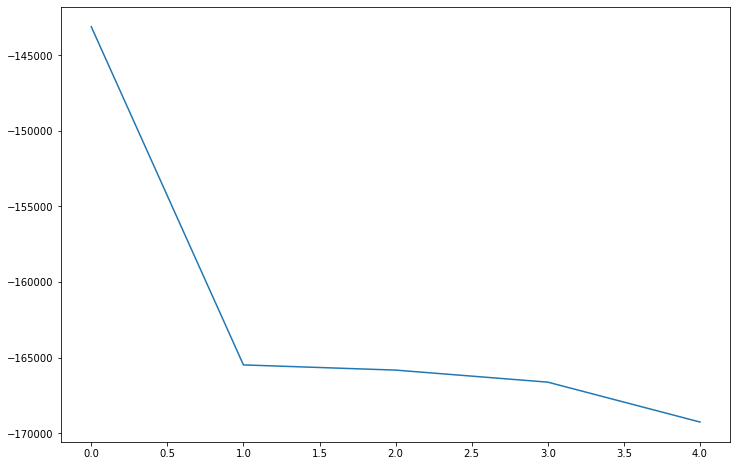

In [13]:
plt.plot(BICs)
plt.show()

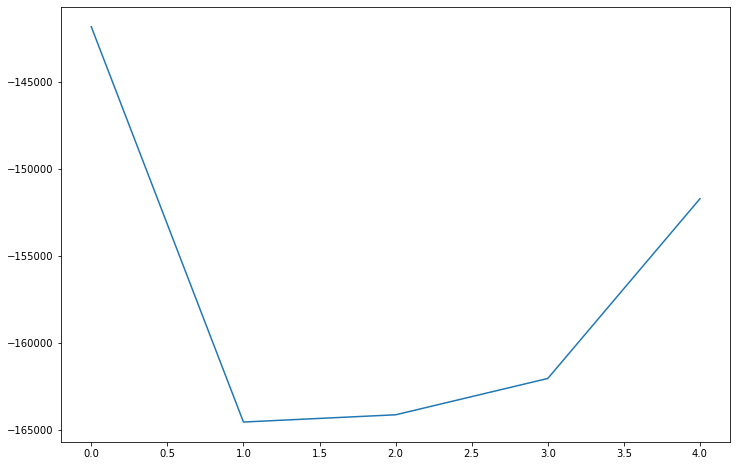

In [14]:
plt.plot(UBICs)
plt.show()

In [15]:
# is_normal = False
# -144228.99857918, -158329.02580668, -170164.43839548, -175517.17871009, -180667.18645263
# is_normal = True -> UBICs suggest more parsimony
# -144228.99857918, -195993.82133994, -204257.2555485, -207577.4900399 , -214587.71087563
BICs

array([-143110.55496557, -165479.82656868, -165823.80939645,
       -166620.39133781, -169258.33054701])